In [63]:
import h5py
import random
import scipy.io
from collections import Counter

from tsne_functions import *

In [64]:
data_path='/home/khrovatin/retinal/data/counts/'

In [79]:
col_data=pd.read_table(data_path+'passedQC_cellData.tsv',index_col=0)
col_by_region=col_data.groupby('region')
fov_cells=col_by_region.get_group('fov').index
per_cells=col_by_region.get_group('per').index

In [66]:
with h5py.File(data_path+'scaledata.h5','r') as file:
    #As h5 file was saved in R it is imported as transposed
    data_int=pd.DataFrame(file.get('integrated/matrix')[:file.get('integrated/matrix').shape[0],:])
    data_int.columns=[name.decode() for name in file.get('integrated/rownames')]
    data_int.index=[name.decode() for name in file.get('integrated/colnames')[:file.get('integrated/colnames').shape[0]]]

In [67]:
with h5py.File(data_path+'normalisedlog.h5','r') as file:    
    data_norm=pd.DataFrame(file.get('ref/matrix')[:file.get('ref/matrix').shape[0],:])
    data_norm.columns=[name.decode() for name in file.get('ref/rownames')]
    data_norm.index=[name.decode() for name in file.get('ref/colnames')[:file.get('ref/colnames').shape[0]]]
    
    data_norm_h=pd.DataFrame(file.get('00012_NeuNM/matrix')[:file.get('00012_NeuNM/matrix').shape[0],:])
    data_norm_h.columns=[name.decode() for name in file.get('00012_NeuNM/rownames')]
    data_norm_h.index=[name.decode() for name in file.get('00012_NeuNM/colnames')[:file.get('00012_NeuNM/colnames').shape[0]]]

In [68]:
counts_h=scipy.io.mmread('/share/LBI_share/public/retina/human snRNAseq data_10x_ChenLab_ZupanLab/humansn_10x_storage/00012_NeuNM_filtered_feature_bc_matrix/matrix.mtx.gz')
counts_h=pd.DataFrame.sparse.from_spmatrix(counts_h).T
counts_h.columns=pd.read_table('/share/LBI_share/public/retina/human snRNAseq data_10x_ChenLab_ZupanLab/humansn_10x_storage/00012_NeuNM_filtered_feature_bc_matrix/features.tsv.gz',header=None)[1]
counts_h.index=pd.read_table('/share/LBI_share/public/retina/human snRNAseq data_10x_ChenLab_ZupanLab/humansn_10x_storage/00012_NeuNM_filtered_feature_bc_matrix/barcodes.tsv.gz',header=None)[0]
counts_h.index=[idx.split('-')[0] for idx in counts_h.index]

In [69]:
genes_duplicated=[k for k,v in Counter(list(counts_h.columns)).items() if v > 1]
genes_duplicated

['CRIP1', 'CRYBG3', 'KRT222', 'MFRP', 'PNRC2', 'SOX7', 'TUBB3']

In [70]:
genes=pd.read_table('/share/LBI_share/public/retina/human snRNAseq data_10x_ChenLab_ZupanLab/humansn_10x_storage/00012_NeuNM_filtered_feature_bc_matrix/features.tsv.gz',header=None)

In [71]:
for gene in genes_duplicated:
    print(genes[genes[1]==gene])
    #print(counts_h.iloc[:,counts_h.columns==gene].sum())

                     0      1                2
23466  ENSG00000213145  CRIP1  Gene Expression
23467  ENSG00000257341  CRIP1  Gene Expression
                    0       1                2
6168  ENSG00000233280  CRYBG3  Gene Expression
6169  ENSG00000080200  CRYBG3  Gene Expression
                     0       1                2
26959  ENSG00000264058  KRT222  Gene Expression
26960  ENSG00000213424  KRT222  Gene Expression
                     0     1                2
19850  ENSG00000235718  MFRP  Gene Expression
19851  ENSG00000259159  MFRP  Gene Expression
                     0      1                2
502    ENSG00000189266  PNRC2  Gene Expression
32731  ENSG00000215700  PNRC2  Gene Expression
                     0     1                2
14395  ENSG00000171056  SOX7  Gene Expression
14396  ENSG00000258724  SOX7  Gene Expression
                     0      1                2
26028  ENSG00000198211  TUBB3  Gene Expression
26030  ENSG00000258947  TUBB3  Gene Expression


Some of these ENS IDs point to deprecated genes/poorly characterized proteins. As their homology in macaque is uncertain based solely on gene symbol they are removed.

In [72]:
print(data_norm_h.shape,data_norm.shape)

for gene in genes_duplicated:
    if gene in data_norm_h.columns:
          data_norm_h=data_norm_h.drop(gene,axis=1)
    if gene in data_norm.columns:
          data_norm=data_norm.drop(gene,axis=1)

print(data_norm_h.shape,data_norm.shape)

(11194, 2203) (156644, 2203)
(11194, 2196) (156644, 2196)


In [74]:
print(counts_h.shape,data_int.shape)
counts_h=counts_h.loc[data_norm_h.index,data_norm.columns]
data_int=data_int[data_norm.columns]
print(counts_h.shape,data_int.shape)

(11245, 32738) (156644, 2196)
(11194, 2196) (156644, 2196)


# tSNE embedding 

In [75]:
tsne_int=make_tsne(data_int)
#savePickle(data_path+'tSNE_integrated_sharedGenes.pkl',(tsne_int,data_int.index))

TypeError: can't pickle DUFunc objects

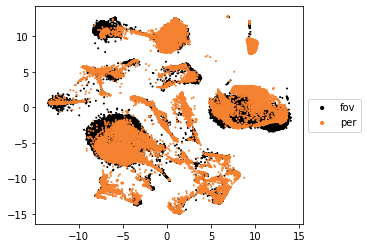

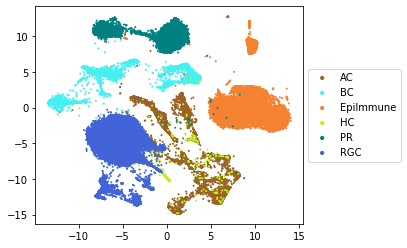

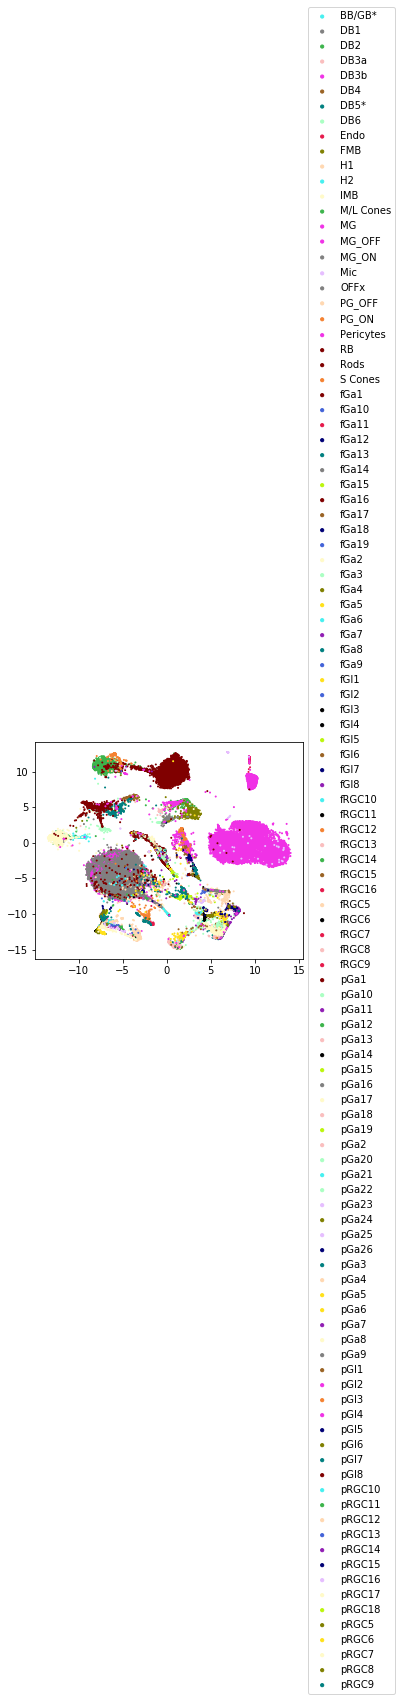

In [82]:
print('By region')
plot_tsne([tsne_int],[dict(zip(col_data.index,col_data['region']))],[ data_int.index], 
          legend=True,plotting_params = {'s': 0.2,'alpha':0.5})
print('By cell type')
plot_tsne([tsne_int],[dict(zip(col_data.index,col_data['cell_type']))], [data_int.index],
          legend=True,plotting_params = {'s': 0.2,'alpha':0.5})
print('By more specific cell type; there are more types than colours')
plot_tsne([tsne_int],[dict(zip(col_data.index,col_data['cell_types_fine']))], [data_int.index],
          legend=False,plotting_params = {'s': 0.2,'alpha':0.5})

In [ ]:
tsne_data_int=analyse_tsne(data1=data_int,data2=counts_h,col_data=col_data,tsne1=tsne_int)

In [ ]:
tsne_int_fov=make_tsne(data_int.loc[fov_cells,:])

In [ ]:
print('By region')
plot_tsne([tsne_int_fov],[dict(zip(col_data.index,col_data['region']))],[ data_int.loc[fov_cells,:].index],
          legend=True,plotting_params = {'s': 0.2,'alpha':0.5})
print('By cell type')
plot_tsne([tsne_int_fov],[dict(zip(col_data.index,col_data['cell_type']))], [data_int.loc[fov_cells,:].index],
          legend=True,plotting_params = {'s': 0.2,'alpha':0.5})
print('By more specific cell type; there are more types than colours')
plot_tsne([tsne_int_fov],[dict(zip(col_data.index,col_data['cell_types_fine']))], [data_int.loc[fov_cells,:].index],
          legend=False,plotting_params = {'s': 0.2,'alpha':0.5})

In [ ]:
tsne_data_int_fov=analyse_tsne(data1=data_int.loc[fov_cells,:],data2=counts_h,col_data=col_data,
                               tsne1=tsne_int_fov)

In [ ]:
tsne_int_per=make_tsne(data_int.loc[per_cells,:])

In [ ]:
print('By region')
plot_tsne([tsne_int_per],[dict(zip(col_data.index,col_data['region']))],[ data_int.loc[per_cells,:].index],
          legend=True,plotting_params = {'s': 0.2,'alpha':0.5})
print('By cell type')
plot_tsne([tsne_int_per],[dict(zip(col_data.index,col_data['cell_type']))], [data_int.loc[per_cells,:].index],
          legend=True,plotting_params = {'s': 0.2,'alpha':0.5})
print('By more specific cell type; there are more types than colours')
plot_tsne([tsne_int_per],[dict(zip(col_data.index,col_data['cell_types_fine']))], [data_int.loc[per_cells,:].index],
          legend=False,plotting_params = {'s': 0.2,'alpha':0.5})

In [ ]:
tsne_data_int_per=analyse_tsne(data1=data_int.loc[per_cells,:],data2=counts_h,col_data=col_data,
                               tsne1=tsne_int_per)